In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import os

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 数据集类
class NPYDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        # 尝试使用'utf-8'或'gbk'编码读取文件
        try:
            self.annotations = pd.read_csv(csv_file, encoding='utf-8')
        except UnicodeDecodeError:
            self.annotations = pd.read_csv(csv_file, encoding='gbk')
        self.root_dir = root_dir
        self.le = LabelEncoder()
        self.annotations['labels'] = self.annotations['labels'].apply(lambda x: x.strip("[]'"))
        self.annotations['labels'] = self.le.fit_transform(self.annotations['labels'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = str(self.annotations.iloc[index, -1]) + '.npy'
        img_path = os.path.join(self.root_dir, img_name)
        image = np.load(img_path)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = self.annotations.iloc[index, 2]
        return image, label

# 模型定义
class ResNet2D(nn.Module):
    def __init__(self, num_classes):
        super(ResNet2D, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# 训练和评估参数
num_epochs = 5
batch_size = 32
learning_rate = 0.001

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据加载
train_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\train.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_train_images')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\test.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_test_images')
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\validation.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_validation_images')
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
num_classes = len(np.unique(train_dataset.annotations['labels']))
model = ResNet2D(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [2]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 确保模型在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 确保模型处于训练模式
model.train()

# 可能需要调整学习率
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)  # 示例学习率

for epoch in range(0, 5):  # 继续训练过程
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # 每个epoch结束后打印损失
    print(f'Epoch [{epoch+1}/{5}], Loss: {loss.item():.4f}')
    
    # 每个epoch结束后在训练集上评估模型
    model.eval()  # 切换到评估模式
    with torch.no_grad():
        train_preds = []
        train_labels = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.view(-1).cpu().numpy())
            train_labels.extend(labels.view(-1).cpu().numpy())
        train_accuracy = 100 * np.sum(np.array(train_preds) == np.array(train_labels)) / len(train_labels)
        print(f'Train Accuracy: {train_accuracy:.2f} %')

    # 每个epoch结束后在验证集上评估模型
    with torch.no_grad():
        val_preds = []
        val_labels = []
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.view(-1).cpu().numpy())
            val_labels.extend(labels.view(-1).cpu().numpy())
        val_accuracy = 100 * np.sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
        print(f'Validation Accuracy: {val_accuracy:.2f} %')
    
    # 每个epoch结束后在测试集上评估模型
    with torch.no_grad():
        test_preds = []
        test_labels = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.view(-1).cpu().numpy())
            test_labels.extend(labels.view(-1).cpu().numpy())
    
        test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
        print(f'Test Accuracy: {test_accuracy:.2f} %')

        # 计算精确率、召回率和F1分数
        precision = precision_score(test_labels, test_preds, average='weighted')
        recall = recall_score(test_labels, test_preds, average='weighted')
        f1 = f1_score(test_labels, test_preds, average='weighted')
    
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
    
    model.train()  # 切换回训练模式

Epoch [1/5], Loss: 0.4919
Train Accuracy: 82.20 %
Validation Accuracy: 75.17 %
Test Accuracy: 79.53 %
Precision: 0.7919
Recall: 0.7953
F1 Score: 0.7923
Epoch [2/5], Loss: 0.4369
Train Accuracy: 82.56 %
Validation Accuracy: 76.85 %
Test Accuracy: 75.84 %
Precision: 0.7924
Recall: 0.7584
F1 Score: 0.7469
Epoch [3/5], Loss: 0.6699
Train Accuracy: 87.39 %
Validation Accuracy: 78.52 %
Test Accuracy: 79.53 %
Precision: 0.8125
Recall: 0.7953
F1 Score: 0.8007
Epoch [4/5], Loss: 0.1446
Train Accuracy: 82.71 %
Validation Accuracy: 76.17 %
Test Accuracy: 77.85 %
Precision: 0.7995
Recall: 0.7785
F1 Score: 0.7681
Epoch [5/5], Loss: 0.0452
Train Accuracy: 73.70 %
Validation Accuracy: 71.14 %
Test Accuracy: 70.81 %
Precision: 0.8529
Recall: 0.7081
F1 Score: 0.6337


In [4]:
# 保存模型权重
model_path = r'C:\Users\HP\Desktop\headgaze\trained_model.pth'  # 指定模型保存路径
torch.save(model.state_dict(), model_path)  # 保存模型权重

In [1]:
model_path = r'C:\Users\HP\Desktop\headgaze\trained_model.pth'  # 指定模型保存路径

In [3]:
# 创建与之前相同的模型实例
# 请将num_classes替换为您实际使用的类别数
model = ResNet2D(num_classes=num_classes)

# 加载保存的模型状态字典，确保映射到CPU
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 如果你要继续在训练模式下使用模型，别忘了调用 model.train()
# 如果是用于评估或预测，调用 model.eval()

<All keys matched successfully>

In [5]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 确保模型在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 确保模型处于训练模式
model.train()

# 可能需要调整学习率
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)  # 示例学习率

for epoch in range(5, 10):  # 继续训练过程
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # 每个epoch结束后打印损失
    print(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')
    
    # 每个epoch结束后在训练集上评估模型
    model.eval()  # 切换到评估模式
    with torch.no_grad():
        train_preds = []
        train_labels = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.view(-1).cpu().numpy())
            train_labels.extend(labels.view(-1).cpu().numpy())
        train_accuracy = 100 * np.sum(np.array(train_preds) == np.array(train_labels)) / len(train_labels)
        print(f'Train Accuracy: {train_accuracy:.2f} %')

    # 每个epoch结束后在验证集上评估模型
    with torch.no_grad():
        val_preds = []
        val_labels = []
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.view(-1).cpu().numpy())
            val_labels.extend(labels.view(-1).cpu().numpy())
        val_accuracy = 100 * np.sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
        print(f'Validation Accuracy: {val_accuracy:.2f} %')
    
    # 每个epoch结束后在测试集上评估模型
    with torch.no_grad():
        test_preds = []
        test_labels = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.view(-1).cpu().numpy())
            test_labels.extend(labels.view(-1).cpu().numpy())
    
        test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
        print(f'Test Accuracy: {test_accuracy:.2f} %')

        # 计算精确率、召回率和F1分数
        precision = precision_score(test_labels, test_preds, average='weighted')
        recall = recall_score(test_labels, test_preds, average='weighted')
        f1 = f1_score(test_labels, test_preds, average='weighted')
    
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
    
    model.train()  # 切换回训练模式

Epoch [6/10], Loss: 0.3348
Train Accuracy: 87.10 %
Validation Accuracy: 78.19 %
Test Accuracy: 78.86 %
Precision: 0.8536
Recall: 0.7886
F1 Score: 0.7732
Epoch [7/10], Loss: 0.2538
Train Accuracy: 94.81 %
Validation Accuracy: 79.87 %
Test Accuracy: 84.23 %
Precision: 0.8553
Recall: 0.8423
F1 Score: 0.8420
Epoch [8/10], Loss: 0.0553
Train Accuracy: 94.96 %
Validation Accuracy: 81.54 %
Test Accuracy: 84.23 %
Precision: 0.8726
Recall: 0.8423
F1 Score: 0.8403
Epoch [9/10], Loss: 0.0879
Train Accuracy: 95.82 %
Validation Accuracy: 81.54 %
Test Accuracy: 83.56 %
Precision: 0.8506
Recall: 0.8356
F1 Score: 0.8356
Epoch [10/10], Loss: 0.0997
Train Accuracy: 90.78 %
Validation Accuracy: 77.85 %
Test Accuracy: 79.53 %
Precision: 0.8509
Recall: 0.7953
F1 Score: 0.7888


In [14]:
model_path = r'C:\Users\HP\Desktop\指南者\项目\组会3\trained_model.pth'  # 指定模型保存路径cdmn

In [15]:
# 加载模型状态字典，确保映射到CPU
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# 修改状态字典的键以匹配模型的期望键
# 这里假设你要将 "fc.weight" 和 "fc.bias" 映射到模型中的 "resnet.fc.weight" 和 "resnet.fc.bias"
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key
    if key == "fc.weight":
        new_key = "resnet.fc.weight"
    elif key == "fc.bias":
        new_key = "resnet.fc.bias"
    new_state_dict[new_key] = value

# 使用修改后的状态字典更新模型
model.load_state_dict(new_state_dict)

# 根据需要调用 model.train() 或 model.eval()

<All keys matched successfully>

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # 收集所有预测和标签
        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

    # 计算准确率
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')
    
    # 计算精确率、召回率和F1分数
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

Accuracy of the model on the test images: 85.91 %
Precision: 0.8638
Recall: 0.8591
F1 Score: 0.8594


In [17]:
# 打印所有预测结果
print('All Predictions:', all_preds)

All Predictions: [3, 3, 1, 2, 2, 3, 0, 0, 3, 1, 2, 3, 1, 3, 0, 0, 3, 0, 0, 2, 2, 1, 2, 3, 3, 1, 2, 0, 2, 0, 0, 0, 0, 2, 1, 3, 0, 2, 3, 3, 1, 2, 2, 1, 0, 1, 0, 1, 2, 2, 3, 3, 3, 3, 2, 1, 3, 1, 0, 3, 0, 2, 3, 2, 2, 0, 0, 0, 1, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 0, 0, 2, 0, 1, 0, 0, 3, 3, 1, 0, 3, 1, 3, 0, 2, 0, 2, 2, 1, 0, 2, 3, 2, 1, 2, 1, 1, 2, 3, 0, 3, 2, 3, 1, 0, 2, 3, 2, 0, 0, 3, 3, 3, 2, 0, 1, 1, 0, 0, 0, 3, 3, 2, 2, 3, 0, 3, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 2, 3, 1, 1, 3, 1, 0, 0, 3, 0, 3, 1, 2, 3, 0, 0, 3, 0, 0, 0, 2, 2, 2, 3, 0, 1, 1, 0, 0, 2, 2, 1, 1, 2, 3, 3, 0, 0, 0, 1, 3, 1, 1, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 1, 2, 0, 3, 1, 3, 3, 0, 2, 0, 2, 0, 3, 3, 3, 0, 3, 0, 1, 0, 1, 2, 1, 1, 2, 3, 1, 0, 2, 3, 3, 0, 1, 1, 1, 1, 2, 1, 1, 0, 3, 3, 3, 3, 0, 2, 3, 0, 2, 3, 2, 3, 0, 0, 2, 0, 1, 3, 2, 0, 0, 3, 2, 3, 1, 3, 3, 0, 1, 0, 0, 1, 1, 3, 2, 0, 1, 0, 1, 0, 0, 3, 1, 3, 3, 1, 0, 1, 3, 3, 1, 2, 0, 3, 2, 2, 2, 0]


In [18]:
# Assuming `le` is your LabelEncoder instance that has been fitted to the labels
print("Label mapping:")
for i, label in enumerate(train_dataset.le.classes_):
    print(f"{label}: {i}")

Label mapping:
C: 0
D: 1
M: 2
N: 3


In [19]:
import torch  
import numpy as np  
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  
  
# 假设model, test_loader, device等都已正确定义和初始化  
  
model.eval()  
with torch.no_grad():  
    all_preds = []  
    all_labels = []  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device).long()  
        outputs = model(images)  
        _, predicted = torch.max(outputs.data, 1)  
          
        # 收集所有预测和标签  
        all_preds.extend(predicted.view(-1).cpu().numpy())  
        all_labels.extend(labels.view(-1).cpu().numpy())  
  
    # 计算准确率  
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)  
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')  
      
    # 计算精确率、召回率和F1分数  
    precision = precision_score(all_labels, all_preds, average='weighted')  
    recall = recall_score(all_labels, all_preds, average='weighted')  
    f1 = f1_score(all_labels, all_preds, average='weighted')  
      
    print(f'Precision: {precision:.4f}')  
    print(f'Recall: {recall:.4f}')  
    print(f'F1 Score: {f1:.4f}')  
  
    # 计算混淆矩阵  
    cm = confusion_matrix(all_labels, all_preds)  
      
    # 计算每个类别的准确率  
    class_accuracy = cm.diagonal() / cm.sum(axis=1)  
      
    # 打印每个类别的准确率  
    for i in range(len(class_accuracy)):  
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')  
  
# 打印所有预测结果（如果需要）  
# print('All Predictions:', all_preds)

Accuracy of the model on the test images: 85.91 %
Precision: 0.8638
Recall: 0.8591
F1 Score: 0.8594
Accuracy for class 0: 0.96
Accuracy for class 1: 0.73
Accuracy for class 2: 0.94
Accuracy for class 3: 0.80


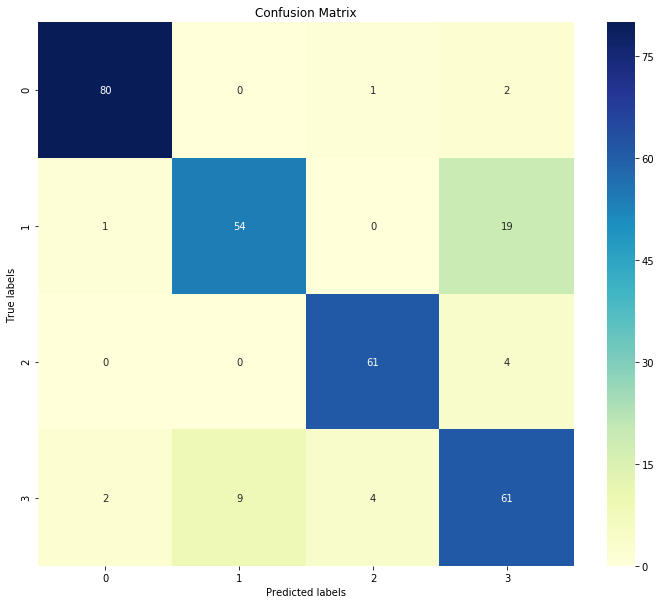

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 基于之前的预测结果计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(12, 10))  # 根据需要调整图像的大小
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(len(np.unique(all_labels))), yticklabels=range(len(np.unique(all_labels))))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()